# Guided Example

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
y2015 = pd.read_csv('LoanStats3d.csv', skipinitialspace=True, header=1)

# Note the warning about dtypes

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach
Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical column and see what happens off of this kind of naive approach.

In [4]:
# from sklearn import ensemble
# from sklearn.model_selection import cross_val_score

# rfc = ensemble.RandomForestClassifier()
# X = y2015.drop('loan_status', 1)
# Y = y2015['loan_status']
# X = pd.get_dummies(X)

# cross_val_score(rfc, X, Y, cv=5)

# Does not work -- crashes the kernel

## Data Cleaning
Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [23]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [24]:
# Convert ID and Interest Rate to numeric
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with more than 30 unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [25]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Remove two summary rows at the end that don't actually contain data
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [9]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,36371250.0,39102635.0,10000.0,10000.0,10000.0,11.99,332.10,31000.0,28.69,0.0,...,0,0,0,0,0,1,0,0,0,0
421091,36441262.0,39152692.0,24000.0,24000.0,24000.0,11.99,797.03,79000.0,3.90,0.0,...,0,0,0,0,0,1,0,0,0,0
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,15.99,316.07,35000.0,30.90,0.0,...,0,0,0,0,0,1,0,0,0,0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,19.99,317.86,64400.0,27.19,1.0,...,0,0,1,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt
Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

X = y2015.drop('loan_status', 1)
X = pd.get_dummies(X) # Are the original categorical variables still present or just the new numerical variables?
X = X.dropna(axis=1)

Y = y2015['loan_status']

cross_val_score(rfc, X, Y, cv=10) # What is this model predicting? The state of the loan. Does that mean it will predict one of the seven possibilities?

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/py

array([0.97492342, 0.98064639, 0.98185747, 0.98169124, 0.96335787,
       0.97532653, 0.93495452, 0.980313  , 0.97962334, 0.9800741 ])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators (or trees in the forest). That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt
So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

### PCA
Used all variables (minus target variable)

In [11]:
# Set feature and target variables
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = y2015.drop('loan_status', 1) # Drop target variable from X prior to PCA, should also look for correlations between features (do not want any negative correlations)
X = pd.get_dummies(X)
X = X.dropna(axis=1)

Y = y2015['loan_status']

# Standardize the features
X = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_,
    '\nThe cumulative percentage of total variance in the dataset explained by',
    'the components from Sklearn PCA.\n',
    pca.explained_variance_ratio_.cumsum()
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.05398192 0.03100909 0.03001029 0.02380851 0.01897283 0.01614592] 
The cumulative percentage of total variance in the dataset explained by the components from Sklearn PCA.
 [0.05398192 0.08499101 0.1150013  0.13880981 0.15778265 0.17392856]


/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


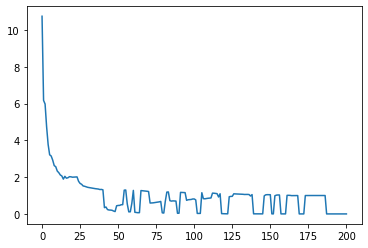

[ 1.07424274e+01+0.00000000e+00j  6.17082352e+00+0.00000000e+00j
  5.97206210e+00+0.00000000e+00j  4.73791190e+00+0.00000000e+00j
  3.77564364e+00+0.00000000e+00j  3.21357484e+00+0.00000000e+00j
  3.14702889e+00+0.00000000e+00j  2.92371680e+00+0.00000000e+00j
  2.62559544e+00+0.00000000e+00j  2.56554441e+00+0.00000000e+00j
  2.32939154e+00+0.00000000e+00j  2.24159049e+00+0.00000000e+00j
  2.11726950e+00+0.00000000e+00j  2.06220462e+00+0.00000000e+00j
  1.89177850e+00+0.00000000e+00j  2.04268761e+00+0.00000000e+00j
  1.94225088e+00+0.00000000e+00j  1.96360284e+00+0.00000000e+00j
  2.02265265e+00+0.00000000e+00j  2.01611188e+00+0.00000000e+00j
  1.99577194e+00+0.00000000e+00j  2.00122713e+00+0.00000000e+00j
  2.00560628e+00+0.00000000e+00j  2.01117818e+00+0.00000000e+00j
  1.77381987e+00+0.00000000e+00j  1.65788191e+00+0.00000000e+00j
  1.60949220e+00+0.00000000e+00j  1.51957843e+00+0.00000000e+00j
  1.50153670e+00+0.00000000e+00j  1.47345274e+00+0.00000000e+00j
  1.44496490e+00+0.000000

In [12]:
# Print scree plot
Xt = X.T
Cx = np.cov(Xt)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

The elbow of the scree plot is around 25, so I will keep the first 25 components, which together explain about 40% of the total variance in the dataset. I will feed these 25 components into the random forest model.

In [13]:
# Use components as features in model
principal_df = pd.DataFrame(data=principal_components)

# Initialize model
rfc = ensemble.RandomForestClassifier()

# Evaluate model using cross validation
cross_val_score(rfc, principal_df, Y, cv=10).mean()

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/py

0.9005875789772615

#### Conclusions
The first 25 components perform pretty well (average of about 93% accuracy) in the random forest model, so then I went back and tried fewer components in an attempt to get the minimum number of components while keeping an average accuracy of 90%. I found the minimum to be 6.

### Use last_pymt_amnt only

In [ ]:
test_list_1 = ['last_pymnt_amnt']

In [ ]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

X = pd.get_dummies(y2015)
X = X.dropna(axis=1)
X = X[test_list_1]

Y = y2015['loan_status']

cross_val_score(rfc, X, Y, cv=10)

#### Conclusions
Last payment amount alone is not enough to create a model with better than 90% accuracy.

### Use out_prncp only

In [ ]:
test_list_2 = ['out_prncp']

In [ ]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

X = pd.get_dummies(y2015)
X = X.dropna(axis=1)
X = X[test_list_2]

Y = y2015['loan_status']

cross_val_score(rfc, X, Y, cv=10)

#### Conclusions
Outstanding principal alone is not enough to create a model with better than 90% accuracy.

### Use correlation as a cutoff to select features

In [31]:
# Get column names for X
X = pd.get_dummies(y2015)
X = X.dropna(axis=1)
for i in X.columns:
    print(i)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
installment
annual_inc
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
total_acc
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
collections_12_mths_ex_med
policy_code
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
avg_cur_bal
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_tl_bal_gt_0
num_sats
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
term_ 36 months
term_ 60 months
grade_A
grade_B
grade_C
grade_D
grade_E
grade_F
grade_G
emp_length_1 year
emp_length_10+ years
emp_length_2 years
emp_length_3 year

In [37]:
# Create list with potential loan status options
loan_status = ['loan_status_Charged Off',
               'loan_status_Current',
               'loan_status_Default',
               'loan_status_Fully Paid',
               'loan_status_In Grace Period',
               'loan_status_Late (16-30 days)',
               'loan_status_Late (31-120 days)']

# Choose r (correlation) cutoff
r_cutoff = 0.72

# Find variables correlated with given loan status option
# above the r (correlation) cutoff and put into list
final_list = []

for status in loan_status:
    temp = X.corr()[status].abs().sort_values(ascending=False)
    temp_list = temp[temp > r_cutoff].index.to_list()
    for i in temp_list:
        if i not in final_list:
            final_list.append(i)

In [38]:
# Check list from above
final_list

['loan_status_Charged Off',
 'loan_status_Current',
 'last_pymnt_d_Jan-2017',
 'loan_status_Fully Paid',
 'next_pymnt_d_Feb-2017',
 'loan_status_Default',
 'last_pymnt_amnt',
 'loan_status_In Grace Period',
 'loan_status_Late (16-30 days)',
 'loan_status_Late (31-120 days)']

In [39]:
# Removing loan status columns from final features list
feature_list = []

for item in final_list:
    if item[0:11] != 'loan_status':
        feature_list.append(item)

# Check final feature list
feature_list

['last_pymnt_d_Jan-2017', 'next_pymnt_d_Feb-2017', 'last_pymnt_amnt']

In [40]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

X = pd.get_dummies(y2015)
X = X.dropna(axis=1)
X = X[feature_list]

Y = y2015['loan_status']

cross_val_score(rfc, X, Y, cv=10)

/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Lisa/opt/anaconda3/lib/py

array([0.91254067, 0.91104462, 0.91080715, 0.93329534, 0.90862028,
       0.91740679, 0.92260562, 0.91163409, 0.9065951 , 0.91191279])

#### Conclusions
I was able to get it down to three features ('last_pymnt_d_Jan-2017', 'next_pymnt_d_Feb-2017', 'last_pymnt_amnt'). I don't think you can do it without using anything related to payment or outstanding principal. My guess is that these features explain the most variance in loan status (ie. are most highly correlated with loan status), so you lose too much information by leaving them out of the model.

Other ideas to consider:
* Try using Cramer's, Thiels, or Correlation Ratio instead of correlation matrices for categorical data. Even with get_dummies, correlation matrices do not work very well for categorical data (just 1s and 0s).

* Look at correlation between out_prncp and last_pymt_amnt. If the two are highly correlated with each other (greater than 0.8), you will only need to use one of them in your model.